# Import all the necessary libraries

In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import catboost as cb

from sklearn.preprocessing import OneHotEncoder, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import Ridge, HuberRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from scipy.stats import skew, norm, probplot
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')

# Load the dataset

In [3]:
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

# Creating a copy of the dataframe to avoid indices conflicts in future
copy_train = train_data.copy()
copy_test = test_data.copy()

In [4]:
copy_train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,Gas

In [5]:
copy_test.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
5,1466,60,RL,75.0,10000,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,763.0,763.0,GasA,Gd,Y,SBrkr,763,892,0,1655,0.0,0.0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.0,Fin,2.0,440.0,TA,TA,Y,157,84,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
6,1467,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,6,7,1992,2007,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,Gd,PConc,Gd,TA,No,ALQ,935.0,Unf,0.0,233.0,1168.0,GasA,Ex,Y,SBrkr,1187,0,0,1187,1.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Attchd,1992.0,Fin,2.0,420.0,TA,TA,Y,483,21,0,0,0,0,NaN,GdPrv,Shed,500,3,2010,WD,Normal
7,1468,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1998,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,789.0,789.0,GasA,Gd,Y,SBrkr,789,676,0,1465,0.0,0.0,2,1,3,1,TA,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,393.0,TA,TA,Y,0,75,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
8,1469,20,RL,85.0,10176,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,7,5,1990,1990,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,Gd,GLQ,637.0,Unf,0.0,663.0,1300.0,GasA,Gd,Y,SBrkr,1341,0,0,1341,1.0,0.0,1,1,2,1,Gd,5,Typ,1,Po,Attchd,1990.0,Unf,2.0,506.0,TA,TA,Y,192,0,0,0,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
9,1470,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,

In [6]:
sample_submission= pd.read_csv("sample_submission.csv")

In [7]:
sample_submission.head(5)

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


This means that we have to keep the id. Because it will be included in the finals submission and the target variable is the **Salesprice**.

In [8]:
housing_dataset = copy_train
test_dataset = copy_test

# Data Outliers Visualization

### Identifying the outliers by comparing the features "LotArea" & "GrLivArea" with SalePrice.


We're comparing the feature LotArea against SalePrice to see if there are any abnormal values. After generating a plot, we can see that there are few values have bigger LotArea but at a very low SalePrice. These values will not be useful to our model, Hence we defined a range and removed the values that fall out of the defined range for two features, i.e., LotArea and GrLivArea againt the SalePrice (Target Variable)

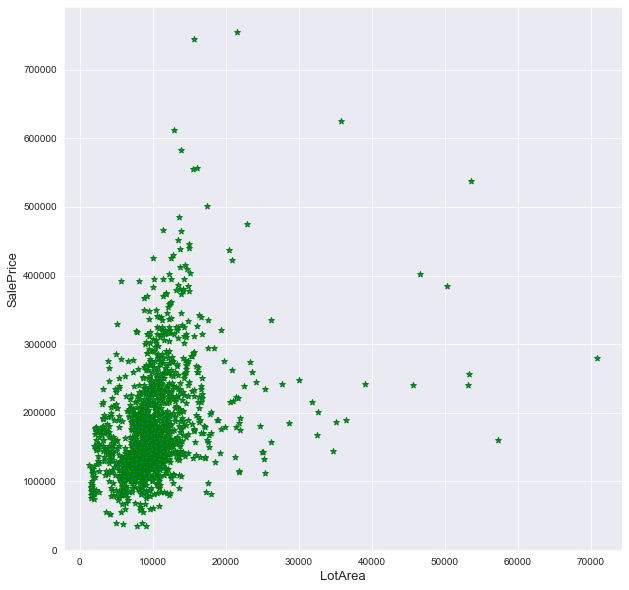

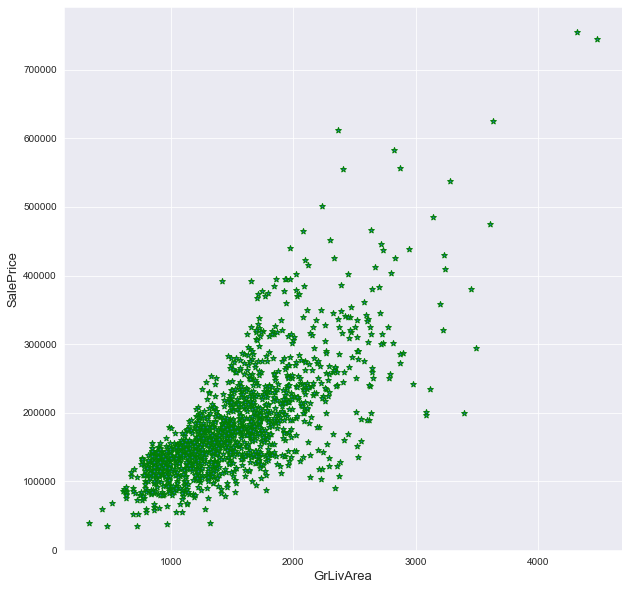

In [36]:
def outlier_visualization(feature):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(x = housing_dataset[feature], y = housing_dataset['SalePrice'], marker = "*", edgecolors = "Green")
    plt.ylabel('SalePrice', fontsize=13)
    plt.xlabel(feature, fontsize=13)
    plt.show()

outlier_visualization('LotArea')
outlier_visualization('GrLivArea')


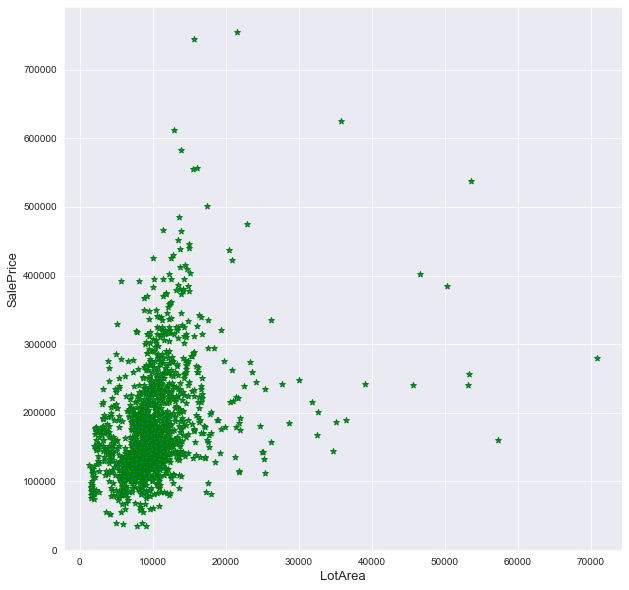

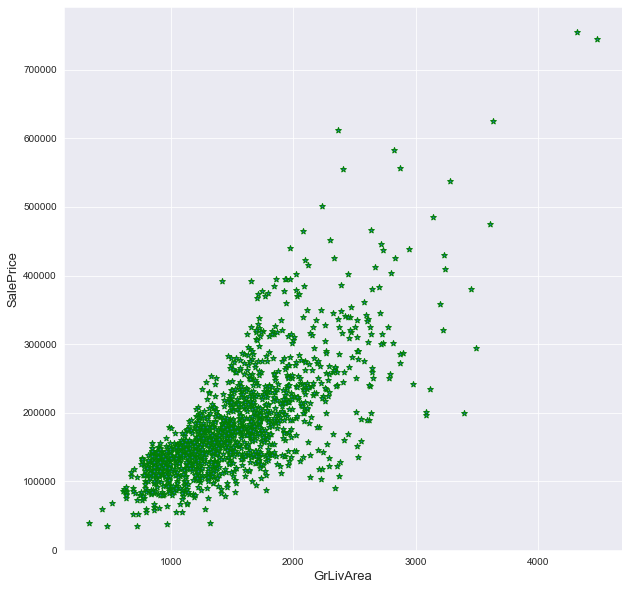

In [19]:
#Deleting outliers by defining the range
housing_dataset = housing_dataset.drop(housing_dataset[(housing_dataset['LotArea']>100000) & (housing_dataset['SalePrice']<400000)].index)

#Lets plot the graph again to see if the outliers are removed.
outlier_visualization('LotArea')

housing_dataset = housing_dataset.drop(housing_dataset[(housing_dataset['GrLivArea']>4000) & (housing_dataset['SalePrice']<300000)].index)
outlier_visualization('GrLivArea')

## Data Correleation

### Correlation map to see how features are correlated with SalePrice

Correlation map to see how features are correlated with SalePrice

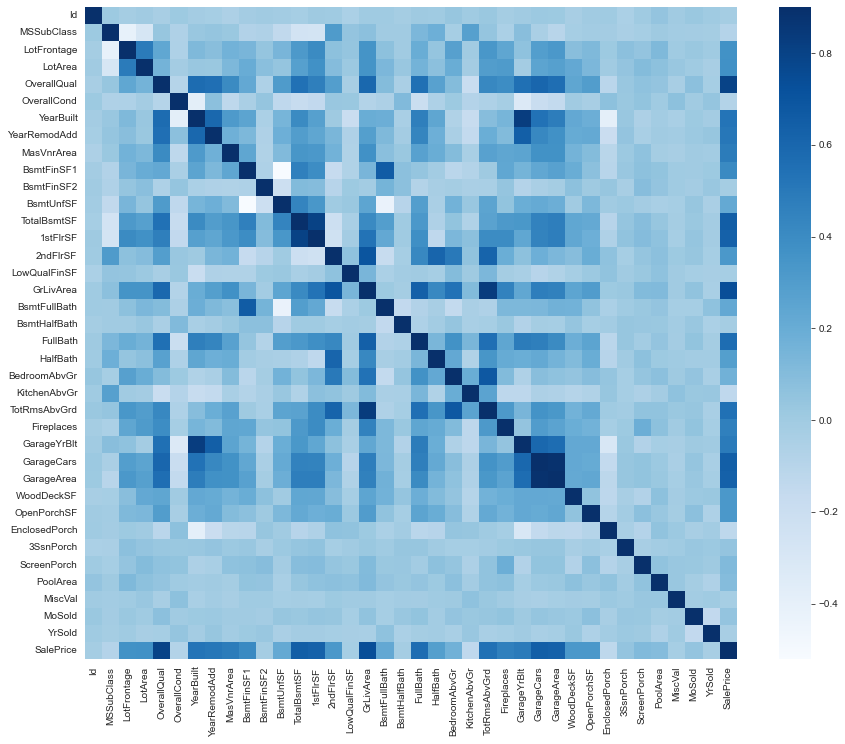

In [38]:
def correlation_matrix():
    corr_matrix = housing_dataset.corr()
    plt.subplots(figsize=(15,12))
    sns.color_palette("bright")
    sns.heatmap(corr_matrix, vmax=0.9, square=True, cmap="Blues")
correlation_matrix()

# Clean the Data

In [ ]:
Current_Saleprice = housing_dataset['SalePrice']

# Save the saleprice in a variable for later comparision,
# and since we need to predict it, drop it from the current housing_dataset
housing_dataset = housing_dataset.drop(['SalePrice'],axis=1)

# set index to ID
housing_dataset = housing_dataset.set_index('Id')
test_dataset = test_dataset.set_index('Id')

housing_dataset.shape

(1458, 79)

In [ ]:
list_of_null_values = []

for col in housing_dataset.columns:
    null = housing_dataset[col].isnull().sum()
    test_null = test_dataset[col].isnull().sum()
    if null != 0 or test_null != 0:
        list_of_null_values.append([col,null,test_null])
        
null_dataframe = pd.DataFrame(list_of_null_values,columns=['Feature_Name','Null','Test_Null'])
null_dataframe.set_index('Feature_Name')
null_dataframe['Total_Null'] = null_dataframe['Null'] + null_dataframe['Test_Null']


## Missing value visualization

-------------------------
Total number of columns with null values:
34
-------------------------
Total number of null values:
13957
-------------------------


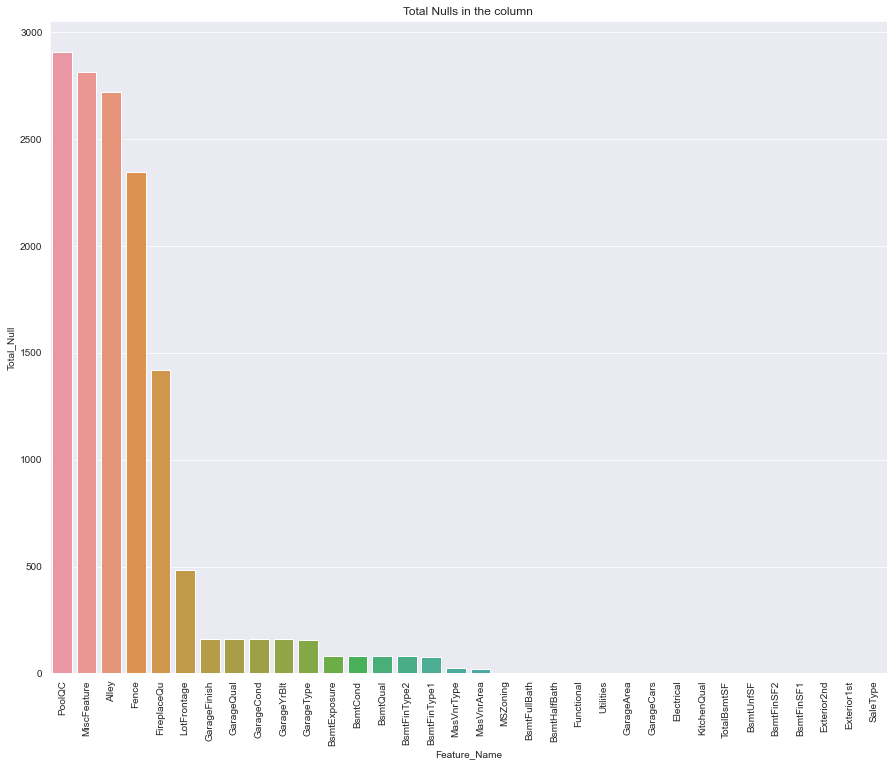

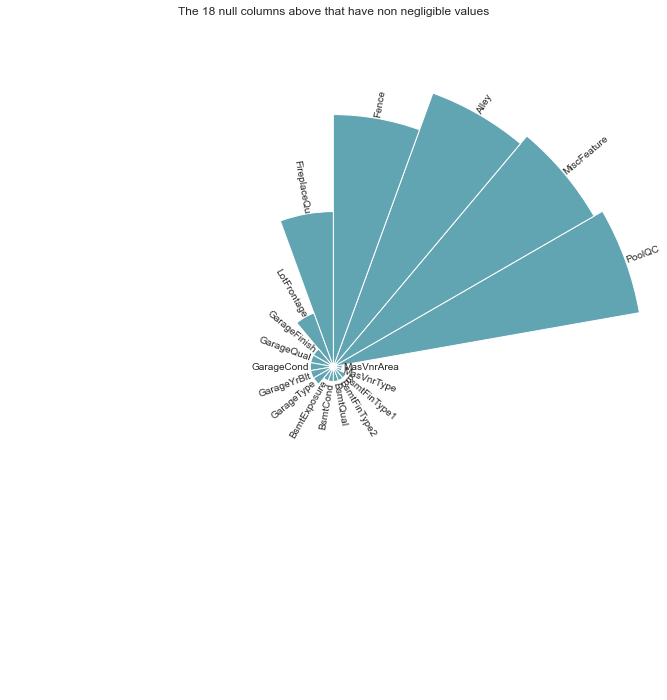

In [ ]:

print("-------------------------")
print("Total number of columns with null values:")
print(len(null_dataframe))
print("-------------------------")
print("Total number of null values:")
print(null_dataframe['Total_Null'].sum(axis=0))
print("-------------------------")

f, ax = plt.subplots(figsize=(15, 12))
sns.set_palette(sns.color_palette("pastel"))
sns.barplot(data=null_dataframe.sort_values(by='Total_Null',ascending = False), x='Feature_Name',y='Total_Null')

plt.xticks(rotation = 90)
plt.title("Total Nulls in the column")
plt.show()

# Sort the null values
null_dataframe = null_dataframe.sort_values(by=['Total_Null'], ascending = False)

# drop the rows with very minor number of null values for visualization purpose (the rows are kept in the main housing_dataset) 
sorted_null_df = null_dataframe.drop(null_dataframe[null_dataframe['Total_Null'] <= 20].index)

# set figure size
plt.figure(figsize=(15, 12))

# plot polar axis
ax = plt.subplot(111, polar=True)

# remove grid
plt.axis('off')
plt.title("The 18 null columns above that have non negligible values") 

# Set the coordinates limits
upperLimit = 100
lowerLimit = 30

# Compute max and min in the dataset
max = sorted_null_df['Total_Null'].max()

# Let's compute heights: they are a conversion of each item value (Total_Null column value) in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * sorted_null_df.Total_Null + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(sorted_null_df.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(sorted_null_df.index)+1))
angles = [element * width for element in indexes]
angles

ax.tick_params(axis='x', labelrotation=10)

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=1, 
    edgecolor="white",
    color="#61a4b2"
)

# little space between the bar and the label
labelPadding = 10

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, sorted_null_df["Feature_Name"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor")
    



## Imputing Missing Values

In [ ]:
# Let's combine our test and training dataset together for further processing
Complete_Test_and_Train_Data = pd.concat([housing_dataset,test_dataset],axis=0).reset_index(drop=True)

### MSZoning (the zoning classification in general): 
The value 'RL' is by far the most popular (MODE). As a result, we can use 'RL' to fill in any missing data in this column.

In [ ]:
Complete_Test_and_Train_Data['MSZoning'] = Complete_Test_and_Train_Data['MSZoning'].fillna(Complete_Test_and_Train_Data['MSZoning'].mode()[0])

### LotFrontage : 
Because the area of each street connected to the house property is most likely similar to the area of other houses in the neighborhood, we may fill in missing numbers by using the community's median LotFrontage.

In [ ]:
# Sort by neighborhood, then use the median Lot value to fill up the blanks. All of the neighborhood's frontage
Complete_Test_and_Train_Data["LotFrontage"] = Complete_Test_and_Train_Data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

### Alley : 
Data description says NA means "no alley access"

In [ ]:
Complete_Test_and_Train_Data["Alley"] = Complete_Test_and_Train_Data["Alley"].fillna("None")

### Utilities : 
For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.

In [ ]:
Complete_Test_and_Train_Data = Complete_Test_and_Train_Data.drop(['Utilities'], axis=1)


### PoolQC : 
Data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.

In [ ]:
Complete_Test_and_Train_Data["PoolQC"] = Complete_Test_and_Train_Data["PoolQC"].fillna("None")

### MiscFeature : 
Data description says NA means "no misc feature"

In [ ]:
Complete_Test_and_Train_Data["MiscFeature"] = Complete_Test_and_Train_Data["MiscFeature"].fillna("None")

### Fence : 
Data description says NA means "no fence"

In [ ]:
Complete_Test_and_Train_Data["Fence"] = Complete_Test_and_Train_Data["Fence"].fillna("None")

### FireplaceQu : 
Data description says NA means "no fireplace"

In [ ]:
Complete_Test_and_Train_Data["FireplaceQu"] = Complete_Test_and_Train_Data["FireplaceQu"].fillna("None")

### GarageType, GarageFinish, GarageQual and GarageCond : 
Replacing missing data with None

In [ ]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    Complete_Test_and_Train_Data[col] = Complete_Test_and_Train_Data[col].fillna('None')

### GarageYrBlt, GarageArea and GarageCars : 
Replacing missing data with 0 (Since No garage = no cars in such garage.)

In [ ]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    Complete_Test_and_Train_Data[col] = Complete_Test_and_Train_Data[col].fillna(0)

### BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : 
missing values are likely zero for having no basement

In [ ]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    Complete_Test_and_Train_Data[col] = Complete_Test_and_Train_Data[col].fillna(0)

### BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : 
For all these categorical basement-related features, NaN means that there is no basement.

In [ ]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    Complete_Test_and_Train_Data[col] = Complete_Test_and_Train_Data[col].fillna('None')

### MasVnrArea and MasVnrType : 
NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.

In [ ]:
Complete_Test_and_Train_Data["MasVnrType"] = Complete_Test_and_Train_Data["MasVnrType"].fillna("None")
Complete_Test_and_Train_Data["MasVnrArea"] = Complete_Test_and_Train_Data["MasVnrArea"].fillna(0)

### Functional : 
data description says NA means typical

In [ ]:
Complete_Test_and_Train_Data["Functional"] = Complete_Test_and_Train_Data["Functional"].fillna("Typ")

### Electrical : 
It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.

In [ ]:
Complete_Test_and_Train_Data['Electrical'] = Complete_Test_and_Train_Data['Electrical'].fillna(Complete_Test_and_Train_Data['Electrical'].mode()[0])

### KitchenQual: 
Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.

In [ ]:
Complete_Test_and_Train_Data['KitchenQual'] = Complete_Test_and_Train_Data['KitchenQual'].fillna(Complete_Test_and_Train_Data['KitchenQual'].mode()[0])

### Exterior1st and Exterior2nd :
Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string

In [ ]:
Complete_Test_and_Train_Data['Exterior1st'] = Complete_Test_and_Train_Data['Exterior1st'].fillna(Complete_Test_and_Train_Data['Exterior1st'].mode()[0])
Complete_Test_and_Train_Data['Exterior2nd'] = Complete_Test_and_Train_Data['Exterior2nd'].fillna(Complete_Test_and_Train_Data['Exterior2nd'].mode()[0])


### SaleType : 
Fill in again with most frequent which is "WD"

In [ ]:
Complete_Test_and_Train_Data['SaleType'] = Complete_Test_and_Train_Data['SaleType'].fillna(Complete_Test_and_Train_Data['SaleType'].mode()[0])

### MSSubClass : 
Na most likely means No building class. We can replace missing values with None

In [ ]:
Complete_Test_and_Train_Data['MSSubClass'] = Complete_Test_and_Train_Data['MSSubClass'].fillna("None")

### Check if there are any more null values in the data set

In [ ]:
list_of_null_values = []

for col in Complete_Test_and_Train_Data.columns:
    null = Complete_Test_and_Train_Data[col].isnull().sum()
    if null != 0:
        list_of_null_values.append([col,null])
        
null_dataframe = pd.DataFrame(list_of_null_values,columns=['Feature_Name','Total_Null'])
null_dataframe.set_index('Feature_Name')

print("-------------------------")
print("Total number of columns with null values:")
print(len(null_dataframe))
print("-------------------------")
print("Total number of null values:")
print(null_dataframe['Total_Null'].sum(axis=0))
print("-------------------------")

Complete_Test_and_Train_Data.shape


-------------------------
Total number of columns with null values:
0
-------------------------
Total number of null values:
0
-------------------------


(2917, 78)

In [ ]:
Complete_Test_and_Train_Data.isnull().sum().sum()

0